# OFDM-Radar-Processing
## Initialisation

In [2]:
!pip install numpy matplotlib scipy

  Using cached matplotlib-3.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
  Using cached contourpy-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (324 kB)

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import math
import sys
import os

#import QPSK-Modulator
#sys.path.append(os.path.abspath("Radar"))
#import Data
f = np.fromfile(open("SDR_Data_alternate_14m"), dtype=np.complex64)
send_syms = np.fromfile(open("send_syms"), dtype=np.complex64)

#initialization Varibels (set in GNU-Radio)
N = int(1024) #IFFT Size in transmitter 
CP = int(N/16) #Cyclic Prefix Size 
fc = 3.65e9 #carrier frequency
B = 56e6 #max bandwidth
frame_len = 256 #Number of OFDM-Symbols in time domain 
Nq_G =  int(N/4) #possible Nyquist-Guard
alternating = True
frame_samples = int((N+CP)*frame_len)#number of samples per frame

if alternating == True:
    
    occ_carr = N//2
    B_a = B
    delta_f = B/N*1/2

else:
    
    occ_carr = N-2*Nq_G
    delta_f = B/N
    B_a = B - delta_f*2*Nq_G
    
      
ofdm_syms = int(occ_carr*frame_len) #ofdm-symbols time and frequency domain
delta_f = B_a/occ_carr #actual subcarrier distance

print('Number Subcarrier',occ_carr)
print('Bandwidth:',B_a*1e-6, 'MHz')
print('Subcarrier Spacing:',delta_f*1e-3, 'kHz')
print('Range Resolution:', np.round(3e8/(2*B_a),1), 'm')
print('Velocity Resolution:', np.round(3e8/(2*fc*frame_samples*1/B)/3.6, 1), 'km/h')
print(send_syms.shape)
print(f.shape)

Number Subcarrier 512
Bandwidth: 56.0 MHz
Subcarrier Spacing: 109.375 kHz
Range Resolution: 2.7 m
Velocity Resolution: 2.3 km/h
(131072,)
(2506752,)


## Framed Processing

In [5]:
#if Data is not reshapeable to [frame_len, (N+CP)] -> problem aso resolved:  
M = f.shape[0]/((N+CP)*frame_len)

M_ceil = math.ceil(M)

M_comp = int(f.shape[0]/((N+CP)*frame_len))

M_rest = f.shape[0]/((N+CP)*frame_len) - M_comp

res = int(math.ceil(M) * ((N+CP)*frame_len))

padding = res - f.size 

f = np.pad(f, (0, padding), mode='constant', constant_values=0)

f = f.reshape(int(M_ceil), int((N+CP)*frame_len))



#frame_len = frame_len -1
#ofdm_syms = int(occ_carr*frame_len)
#f = f[:, :-(N+CP)]
print(f.shape[0]*f.shape[1])
print(occ_carr)
print(M)

2506752
512
9.0


## Display diffrent received Frames

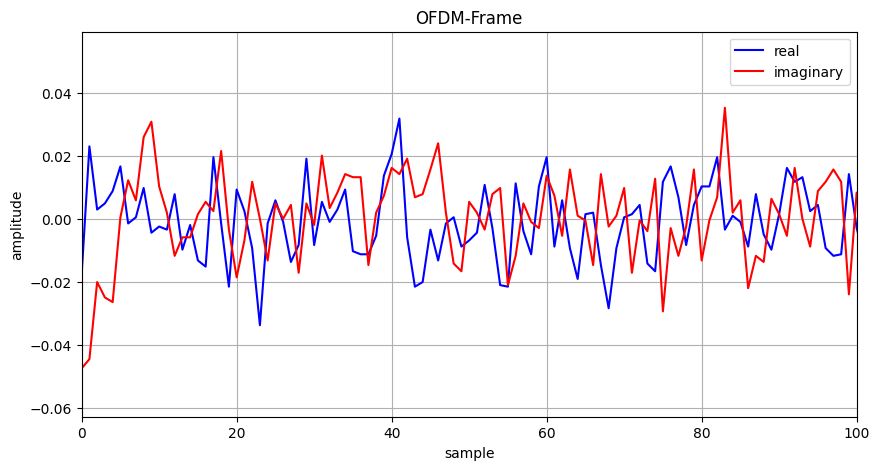

In [6]:
#plot of the ofdm symbols in time domain of one frame f[x] ... x is the frame in range of captured transmissions (1 every second)

real_part = np.real(f[0])
imag_part = np.imag(f[0])

plt.figure(figsize=(10, 5))
plt.plot(real_part, label="real", color="blue")
plt.plot(imag_part, label="imaginary", color="red")

plt.xlabel("sample")
plt.ylabel("amplitude")
plt.title("OFDM-Frame")
plt.xlim(0,100)
plt.legend()
plt.grid()

plt.show()


## Choose Receive Frame for Radar Processing

In [7]:
#choose one of the detected bursts or Frames
frame = f[1]

## Display of the Frame

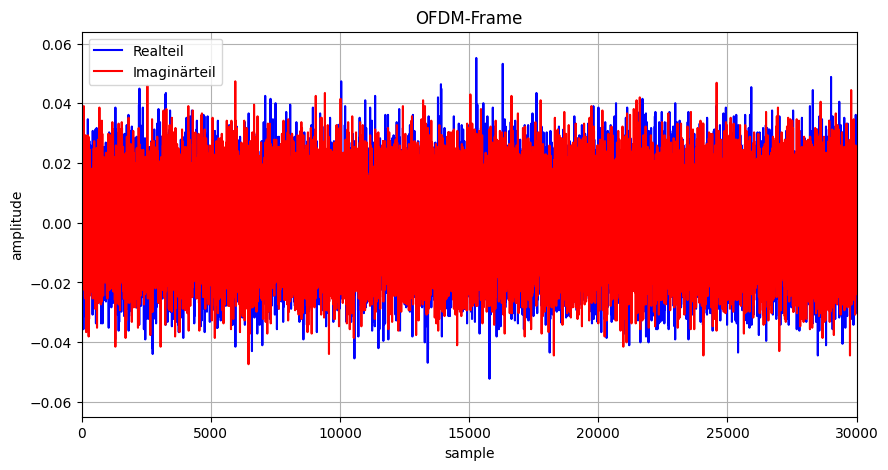

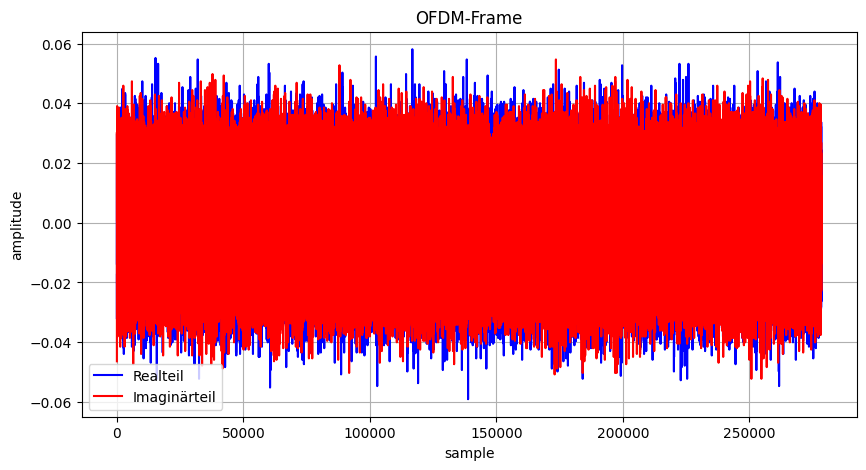

In [8]:
#plot of further processed Frame

real_part = np.real(frame)
imag_part = np.imag(frame)

plt.figure(figsize=(10, 5))
plt.plot(real_part, label="Realteil", color="blue")
plt.plot(imag_part, label="Imaginärteil", color="red")

plt.xlabel("sample")
plt.ylabel("amplitude")
plt.title("OFDM-Frame")
plt.xlim(0,30000)
plt.legend()
plt.grid()

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(real_part, label="Realteil", color="blue")
plt.plot(imag_part, label="Imaginärteil", color="red")

plt.xlabel("sample")
plt.ylabel("amplitude")
plt.title("OFDM-Frame")
#plt.xlim(ofdm_syms-occ_carr,ofdm_syms)
plt.legend()
plt.grid()

plt.show()


## Remove CP and calculate FFT of received Frames to obtain received modulation symbols

In [9]:
# exclude CP and calculate FFT for every ofdm-symbol in time domain

fft_syms = []
symbol_oCP = []
for i in range(frame_len): # capture span was over one frame 
    symbol_wCP = frame[int(i * (N + CP)): int((i + 1) * (N + CP))]
    symbol = symbol_wCP[CP:]
    symbol_oCP.append(symbol)
    fft_sym = np.fft.fft(symbol)
    fft_shift = np.fft.fftshift(fft_sym)
    fft_syms.append(fft_shift)

fft_syms = np.array(fft_syms, dtype=complex)

fft_syms.shape

(256, 1024)

## Frequency Spectrum of received Signal

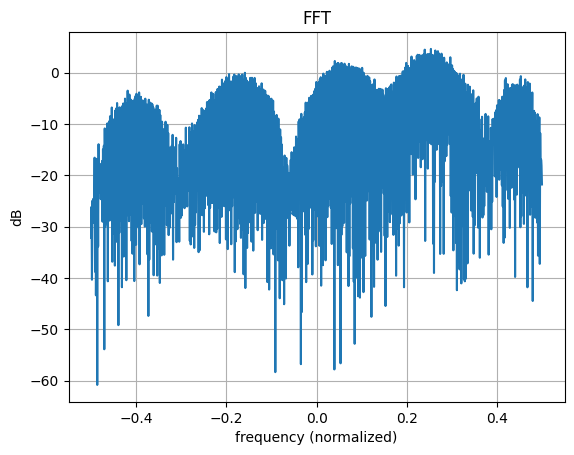

In [10]:
#show spectrum of one of the symbols from captured OFDM frame



fft_syms_r = fft_syms

fft_syms_r.reshape((N, int(frame_len)))

amplitude = np.abs(fft_syms_r)
magnitude = 10*np.log(amplitude)
frequencies = np.fft.fftfreq(fft_syms_r.shape[1])
shifted_frequencies = np.fft.fftshift(frequencies)  #shift DC to th middle

plt.plot(shifted_frequencies, magnitude[0]) # -> choose the spectrum of wich symbol to display
plt.title("FFT")
plt.xlabel("frequency (normalized)")
plt.ylabel("dB")
plt.grid(True)
plt.show()

## Select occupied Carrier

In [11]:
#only select actual occupied carrier
if alternating == True:
    fft_syms_xNq = fft_syms[:,1::2]

else:
    fft_syms_xNq = fft_syms[:,Nq_G:int(N-Nq_G)]


fft_syms_xNq.shape

(256, 512)

## Display Spectrum of occupied Carrier

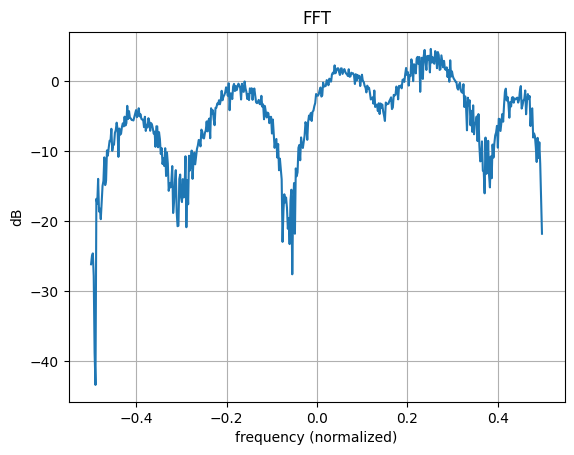

In [12]:
#show spectrum of selcetd carrier
fft_syms_xNq_r = fft_syms_xNq
fft_syms_xNq_r.reshape((fft_syms_xNq.shape[1], frame_len))

amplitude = np.abs(fft_syms_xNq_r)
magnitude = 10*np.log(amplitude)

frequencies = np.fft.fftfreq(fft_syms_xNq.shape[1])
shifted_frequencies = np.fft.fftshift(frequencies)  # DC to the middle

plt.plot(shifted_frequencies, magnitude[0]) # -> choose spectrum of which symbol to display
plt.title("FFT")
plt.xlabel("frequency (normalized)")
plt.ylabel("dB")
plt.grid(True)
plt.show()

## Calculate Channel response from received and sent modulation symbols

In [13]:
# dividision with send symbols -> get channel response 
fft_syms_xNq_f = fft_syms_xNq.flatten()
recv_syms = fft_syms_xNq_f

syms = recv_syms / send_syms
syms_flat = syms
w0 = signal.get_window('hamming', occ_carr)
w1 = signal.get_window('hamming', frame_len)
W, V = np.meshgrid(w0, w1)
Window = W*V

syms = syms.reshape(frame_len, occ_carr)
syms *= Window
 

s = 8
k = 4
syms_pad = np.pad(syms, pad_width=((int(s*frame_len), int(s*frame_len)), (0, int(k*occ_carr))), mode='constant', constant_values=0)
print(syms_pad.shape)
print(Window.shape)
print(syms.shape)



(4352, 2560)
(256, 512)
(256, 512)


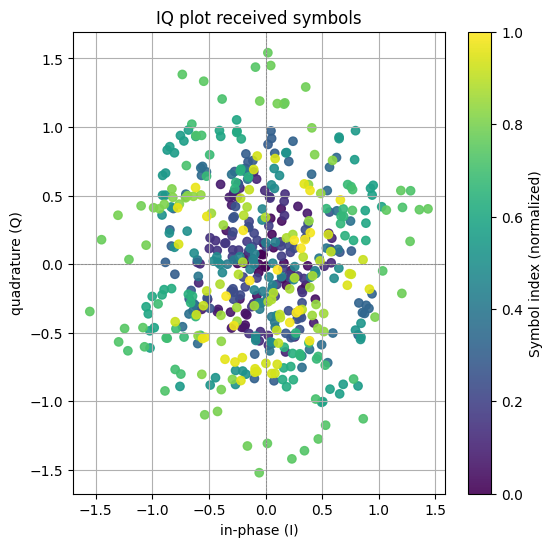

In [14]:
# Angenommen, syms enthält die demodulierten Symbole
# Falls syms komplex ist, extrahieren wir die I- und Q-Komponenten

# Angenommen, rotated_syms[0] enthält die demodulierten Symbole
I = recv_syms[:occ_carr].real
Q = recv_syms[:occ_carr].imag

# Erstelle eine Farbskala basierend auf der Indexposition
colors = np.linspace(0, 1, len(I))

# Erstelle den IQ-Plot mit Farbverlauf
plt.figure(figsize=(6,6))
plt.scatter(I, Q, c=colors, cmap='viridis', alpha=0.9, marker='o')

# Achsenbeschriftungen und Titel
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("in-phase (I)")
plt.ylabel("quadrature (Q)")
plt.title("IQ plot received symbols")

# Farbskala hinzufügen
plt.colorbar(label="Symbol index (normalized)")

plt.grid(True)
plt.show()

512


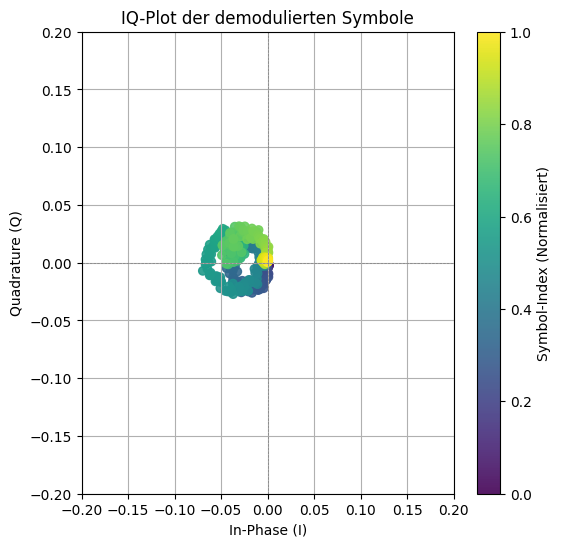

In [15]:
exclude = syms_flat

# Angenommen, rotated_syms[0] enthält die demodulierten Symbole
I = exclude[:occ_carr].real
Q = exclude[:occ_carr].imag
print(len(I))
# Erstelle eine Farbskala basierend auf der Indexposition
colors = np.linspace(0, 1, len(I))

# Erstelle den IQ-Plot mit Farbverlauf
plt.figure(figsize=(6,6))
plt.scatter(I, Q, c=colors, cmap='viridis', alpha=0.9, marker='o')

# Achsenbeschriftungen und Titel
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("In-Phase (I)")
plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)
plt.ylabel("Quadrature (Q)")
plt.title("IQ-Plot der demodulierten Symbole")

# Farbskala hinzufügen
plt.colorbar(label="Symbol-Index (Normalisiert)")

plt.grid(True)
plt.show()

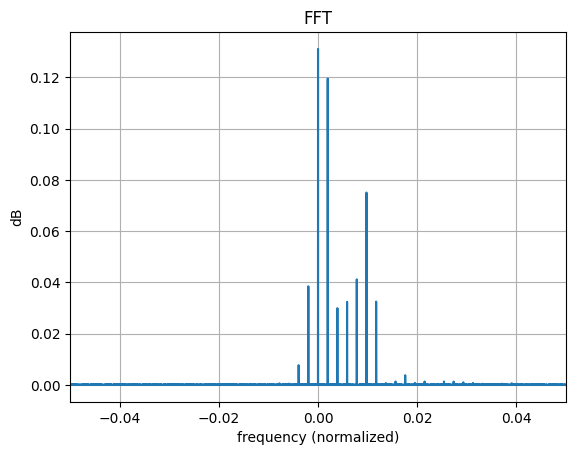

In [16]:
exclude_fft = np.fft.ifft(exclude)
exclude_fft = np.fft.fftshift(exclude_fft)

amplitude = np.abs(exclude_fft)
magnitude = 10*np.log(amplitude)

frequencies = np.fft.fftfreq(exclude_fft.shape[0])
shifted_frequencies = np.fft.fftshift(frequencies)  # DC to the middle

plt.plot(shifted_frequencies, amplitude) # -> choose spectrum of which symbol to display
plt.title("FFT")
plt.xlabel("frequency (normalized)")
plt.ylabel("dB")
plt.xlim(-0.05, 0.05)
plt.grid(True)
plt.show()

2560


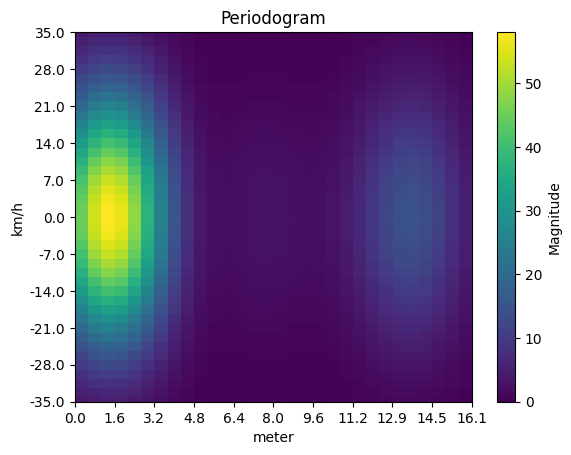

In [17]:
#Radar Processing

#FFT in time domain
RD_Map = np.fft.fft(syms_pad, axis=0)

#IFFT in frequency domain
RD_Map = np.fft.ifft(RD_Map, axis=1)

#shift because doppler maybe negative 
RD_Map = np.fft.fftshift(RD_Map, axes=0)
#Magnitude squared of RD_Map
RD_Map = np.abs(RD_Map)**2

Y_ax = RD_Map.shape[0]//2
X_ax = RD_Map.shape[1]
print(RD_Map.shape[1])
#calculate distance and velocity
tau = np.arange(0, occ_carr, 1/(k+1))/(occ_carr*delta_f)
dist = 3e8*tau/2
dist = np.round(dist, 1)

fd = np.arange(-frame_len//2, frame_len//2, 1/(s*2+1))/((N+CP)*frame_len*1/B)
fd_round = np.round(fd, 1)
vel = 3.6*fd*3e8/(2*fc)
vel = np.round(vel, 1)


#plot is cutted on the upper edge due to a even ammount of symbols
plt.imshow(RD_Map, cmap='viridis', interpolation='none', aspect='auto', origin="lower", extent=[0, X_ax, Y_ax, -Y_ax+1])
plt.colorbar(label="Magnitude")
plt.xticks(np.arange(0, int(X_ax), 3), labels=dist[::3]) # choose tick delta -> 1/5 of xlim (actual displayed distance) seems suffitiend
plt.yticks(np.arange(-Y_ax, Y_ax, 4), labels=vel[::4]) #choose tick delta 
plt.xlim(0,30) #choose displayed distance
plt.ylim(-20,20)
plt.title("Periodogram")
plt.xlabel("meter")
plt.ylabel("km/h")

plt.show()